<img src="https://c9k9c9v3.stackpathcdn.com/wp-content/uploads/2018/04/PH-mobile-payment-providers-go-into-acceleration-mode-1440x564_c.jpg?x82653">

### **Context**

There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

### **Content**

PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

### **Headers**

**Sample Row**

1 | PAYMENT | 1060.31 | C429214117 | 1089.0 | 28.69 | M1591654462 | 0.0 | 0.0 | 0 | 0


**Brief Description of each column**

1. **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

2. **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

3. **amount** - amount of the transaction in local currency.

4. **nameOrig** - customer who started the transaction

5. **oldbalanceOrg** - initial balance before the transaction

6. **newbalanceOrig** - new balance after the transaction

7. **nameDest** - customer who is the recipient of the transaction

8. **oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

9. **newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

10. **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

11. **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.

### **Objective**

1. To find patterns that indicates a transactions as fraud by exploring through Exploratory Data Analysis
2. To build a model based on set of properly selected data and applied strategies for improvement of model performance.
3. To evaluate the quality of the dataset 

#### **Importing Libraries and Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Download the dataset here: https://www.kaggle.com/datasets/ealaxi/paysim1

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv', nrows=108_700)
orig_df = df.copy()
df[df.type =="PAYMENT"]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
108690,10,PAYMENT,3144.08,C170205672,0.00,0.00,M1864477457,0.0,0.0,0,0
108691,10,PAYMENT,2194.73,C1030484400,81470.32,79275.59,M682269001,0.0,0.0,0,0
108692,10,PAYMENT,8367.96,C186898389,79275.59,70907.63,M1773706371,0.0,0.0,0,0
108693,10,PAYMENT,27945.46,C196871797,70907.63,42962.17,M2007017114,0.0,0.0,0,0


### **I. Exploratory Data Analysis**

#### **Column Information**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108700 entries, 0 to 108699
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            108700 non-null  int64  
 1   type            108700 non-null  object 
 2   amount          108700 non-null  float64
 3   nameOrig        108700 non-null  object 
 4   oldbalanceOrg   108700 non-null  float64
 5   newbalanceOrig  108700 non-null  float64
 6   nameDest        108700 non-null  object 
 7   oldbalanceDest  108700 non-null  float64
 8   newbalanceDest  108700 non-null  float64
 9   isFraud         108700 non-null  int64  
 10  isFlaggedFraud  108700 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 9.1+ MB


**Based from this info, we could separate the columns into:**

- **Numerical**: step, amount, oldlbalanceOrig, newbalanceOrig, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud

- **Non-numerical**: type, nameOrig, nameDest

#### **Checking for rows with missing values**

In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

**The dataset doesn't have missing values.**

#### **Exploring each columns**

#### **1. Step**

> **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).


Due to memory constraints, only about 10 hours worth of transactional data was included (step 1 to 10). Nonetheless, let's do find some information based on what we have.

[Text(0.5, 1.0, 'Number of Transactions per Step')]

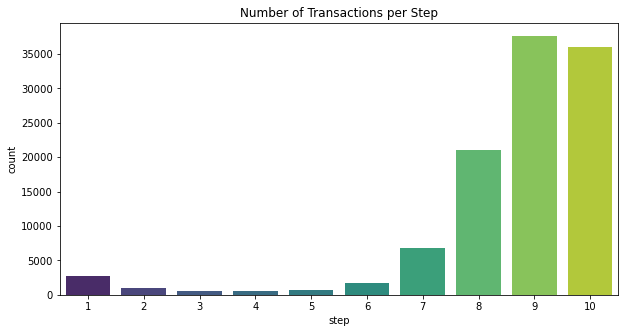

In [5]:
plt.figure(figsize=(10,5))
sns.countplot(
    x = 'step', 
    data = df, 
    palette = 'viridis'
).set(title='Number of Transactions per Step')

[Text(0.5, 1.0, 'Number of FRAUD Transactions per Step')]

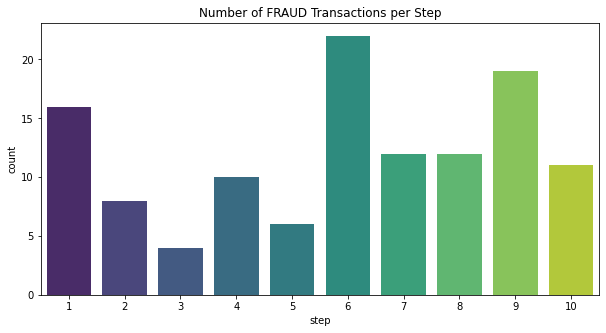

In [6]:
isFraud_df = df[df.isFraud == True]
notFraud_df = df[df.isFraud == False]

plt.figure(figsize=(10,5))
sns.countplot(
    x = 'step', 
    data = isFraud_df, 
    palette = 'viridis'
).set(title='Number of FRAUD Transactions per Step')

**Analysis:**

- There are small amount of transactions from step 1 to step 6. This would make sense if the dataset starts at 00:00 mn, since most people are asleep during 1 am to 6 am
- An increasing trend of transactions is shown starting from step 5 onwards. As people starts to wake up, more people use the application and use it for transactions.
- Most fraud transactions occur on step 6, 9 and 1. It's hard to make sense of why there are more number of fraud transactions during these steps, especially that we have only 10 hours worth of data.  

**Conclusion:**

Due to memory constraints, we can only use a portion of the data. Thus, I decided to drop this for now, and get back to this in the future. For now, we'll try to create a model without this. 

But, I think that this column could be included as one of the features. Specifically, we may use this to get some pattern on when fraud transaction happens. One of the problems that this data may answer is that, *"Is there a certain day or hour where fraud transaction takes place?"*

In [7]:
def drop_column(df, column_name):
    if column_name in df.columns:
        df.drop(column_name, axis=1, inplace=True)
        print(f'{column_name} column is dropped from the given dataframe.')
    else:
        print(f'{column_name} column does not exist in the given dataframe.')

In [8]:
drop_column(df, 'step')

step column is dropped from the given dataframe.


#### **2. Transaction Type**

>**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**Let's view the distribution for each payment type category**

[Text(0.5, 1.0, 'Payment Type Distribution')]

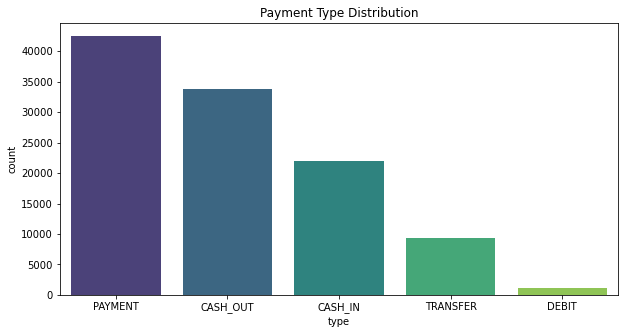

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(
    x = 'type', 
    data = df, 
    palette = 'viridis',
    order = df['type'].value_counts().index
).set(title='Payment Type Distribution')

[Text(0.5, 1.0, 'Fraud Payments per Payment Type Distribution')]

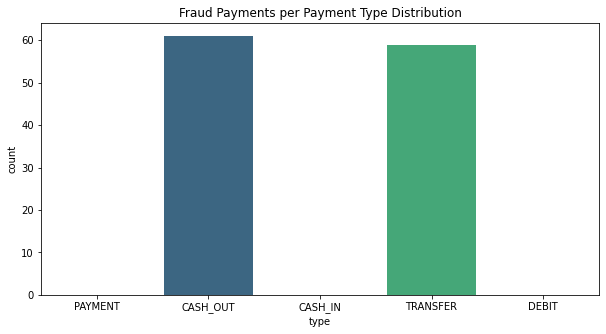

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(
    x = 'type', 
    data = isFraud_df, 
    palette = 'viridis',
    order = df['type'].value_counts().index
).set(title='Fraud Payments per Payment Type Distribution')

**Analysis:**

- The most common transaction used is **Payment** (Customer to Merchants)
- The plot shows that **fraud** transactions only occurs on **cash out** and **transfer** transactions. 
- The act of removing the money from an account by transferring it to another account and then cashing out that money from the system is a potential fraud transaction.

**Conclusion:**

This column needs to undergo **one-hot-encoding** for us to be able to use it as a feature for building our model. Once each category got process, I think we don't need to use all categories, and instead **just use the cashout and transfer category** for our model.

In [11]:
if 'type' in df.columns:
    type_df = pd.get_dummies(df.type, prefix='type')

    if ~type_df.columns.isin(df.columns).any():
        features_df = df.drop('isFraud', axis=1)
        df = pd.concat([features_df, type_df.type_CASH_OUT, type_df.type_TRANSFER, df.isFraud], axis=1)
df

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_TRANSFER,isFraud
0,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,0
1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,0
2,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,0,1,1
3,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,1,0,1
4,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
108695,CASH_OUT,398389.64,C1331269270,3296473.73,2898084.08,C1140712423,579238.38,753051.86,0,1,0,0
108696,CASH_OUT,452251.43,C616412838,447870.63,0.00,C1186254299,0.00,518654.03,0,1,0,0
108697,PAYMENT,5264.12,C1457209565,0.00,0.00,M1988447928,0.00,0.00,0,0,0,0
108698,CASH_OUT,239552.64,C1974162368,274.00,0.00,C1398917188,92780.56,0.00,0,1,0,0


In [12]:
# Dropping type column after one hot encoding
drop_column(df, 'type')

type column is dropped from the given dataframe.


#### **3. Transaction Amount**

> **amount** - amount of the transaction in local currency.

**Assumptions:**

- Usually, banks set a certain limit on the amount of transactions an account can have on a day to prevent cases of money laundering. If the account reach the threshold, it usually halts the transaction and the account holder needs to prove first if the money in the transaction is clean before it proceeds. Therefore, transactions with large amount must be flagged as fraud transactions.


**Let's try to look at the distribution of amount transaction for fraud and non fraud transactions.**

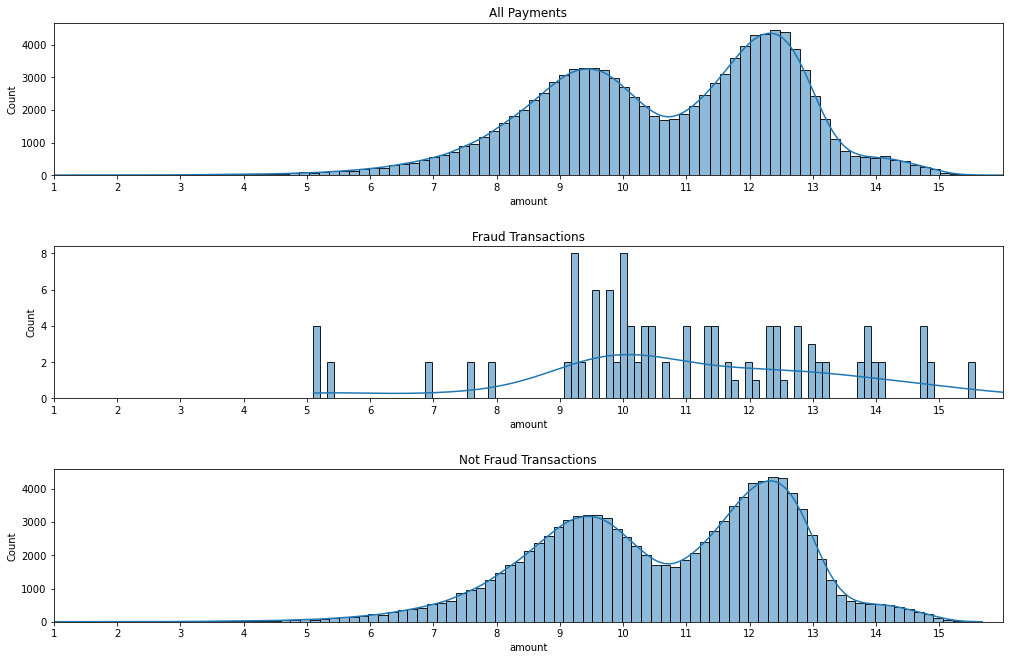

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
fig.tight_layout(pad=5)

transform = np.log(df['amount'] + 1)
sns.histplot(ax=axes[0],data=df, x=transform, kde=True, bins=100).set_title('All Payments')

transform = np.log(isFraud_df['amount'] + 1)
sns.histplot(ax=axes[1],data=isFraud_df, x=transform, kde=True, bins=100).set_title('Fraud Transactions')

transform = np.log(notFraud_df['amount'] + 1)
sns.histplot(ax=axes[2],data=notFraud_df, x=transform, kde=True, bins=100).set_title('Not Fraud Transactions')

# Set fixed x range
for x in range(0,3):
    axes[x].set_xlim(1,16)
    axes[x].set_xticks(range(1,16))

**Findings:**

- Due to the skewness of the distribution, we applied **log transformation** to have a better view of the distributions. 
- The distribution of fraud payments **doesn't show some patterns** that differentiate it from non fraud payments.

**Let's check a summary of descriptive statistics of each distributions.**

In [14]:
pd.concat([
    df.amount.describe().apply(lambda x: format(x, 'f')),
    isFraud_df.amount.describe().apply(lambda x: format(x, 'f')),
    notFraud_df.amount.describe().apply(lambda x: format(x, 'f'))
], keys=['All', 'Fraud', 'Not Fraud'], axis = 1)

,All,Fraud,Not Fraud
count,108700.000000,120.000000,108580.000000
mean,175710.200714,568058.339667,175276.587004
std,347614.067514,1535218.666546,343825.051815
min,0.320000,164.000000,0.320000
25%,10181.742500,16671.960000,10176.047500
50%,55005.195000,39077.815000,55018.670000
75%,214011.132500,350705.740000,213914.720000
max,10000000.000000,10000000.000000,6419835.270000


**Findings:**
- The max transaction amount made reached **10,000,000** and is labeled as **Fraud**.
- The highest transaction that is labeled as **Not Fraud** amounts to **6,419,835**. If our assumption is valid, this must have been flagged as fraud
- The **minimum fraud transaction amount** is **181**. This invalidates any assumptions that fraud transactions are usually high in amount.

**Conclusion:**

I think that the amount is a weak indicator for predicting fraud transactions for this dataset. Nonetheless, I'll leave it as it might be useful for predicting the extremes from both sides of the distribution. 

Since the range of amount values, we may perform scaling or normalization and find out if there will be significant improvement to the model.  

#### **4. Old and New Balance of both Receiver and Sender**

>**oldbalanceOrg** - initial balance before the transaction
>
>**newbalanceOrig** - new balance after the transaction
>
>**oldbalanceDest** - initial balance recipient before the transaction. Note that there is no information for customers that start with M (Merchants).
>
>**newbalanceDest** - new balance recipient after the transaction. Note that there is no information for customers that start with M (Merchants).



**Initial Assumptions:**
1. oldbalanceOrg - newbalanceOrig = amount
2. newbalanceDest - oldbalanceDest = amount
3. If there is a row that doesn't agree in assumption 1 or 2, is it right to assume that it must be fraud?


In [15]:
orig_balance_change = df.oldbalanceOrg - df.newbalanceOrig
is_correct_orig_balance = (df.amount == orig_balance_change)
is_correct_orig_balance.name = 'is_correct_orig_balance'
is_correct_orig_balance.value_counts()

False    100791
True       7909
Name: is_correct_orig_balance, dtype: int64

In [16]:
dest_balance_change = df.newbalanceDest - df.oldbalanceDest
is_correct_dest_balance = df.amount == dest_balance_change
is_correct_dest_balance.name = 'is_correct_dest_balance'
is_correct_dest_balance.value_counts()

False    104369
True       4331
Name: is_correct_dest_balance, dtype: int64

**Findings:**

- Initial assumption 1 and 2 are invalid, the majority of the change in balance doesn't reflect on the amount of the transaction.
- Initial assumption 3 must also be invalid. Since the majority doesn't apply initial assumption 1 and 2, the majority must be fraud for this to be valid. 

**Question:** If the orig_balance_change and dest_balance_change is equal to the amount, is it safe to assume that the transaction is not fraud?

In [17]:
df3 = pd.concat([
        is_correct_orig_balance, 
        is_correct_dest_balance,
        df.isFraud
    ], 
    axis=1)
df4 = df3[df3['is_correct_orig_balance'] & df3['is_correct_dest_balance']] 
correct_balance_fraud = df4[df4.isFraud == 1]
correct_balance_fraud.head(5)

,is_correct_orig_balance,is_correct_dest_balance,isFraud
1870,True,True,1
2302,True,True,1
3060,True,True,1
4104,True,True,1
4261,True,True,1


**Answer:** The transaction can be fraud, even if the amount reflects the change on the old balance and new balance. both on orig/sender and dest/receiver

**Let's try observing the rows of fraud transactions with correct orig and dest balance.**

In [18]:
index_list = correct_balance_fraud.index.tolist()
correct_balance_fraud_df = df.iloc[index_list]
correct_balance_fraud_df

,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_TRANSFER,isFraud
1870,25071.46,C1275464847,25071.46,0.0,C1364913072,9083.76,34155.22,0,1,0,1
2302,235238.66,C1499825229,235238.66,0.0,C2100440237,0.00,235238.66,0,1,0,1
3060,1096187.24,C77163673,1096187.24,0.0,C644345897,0.00,1096187.24,0,1,0,1
4104,10539.37,C1984954272,10539.37,0.0,C124540047,0.00,10539.37,0,1,0,1
4261,22877.00,C2126545173,22877.00,0.0,C573200870,0.00,22877.00,0,1,0,1
4668,169941.73,C2026325575,169941.73,0.0,C1394526584,0.00,169941.73,0,1,0,1
4694,13707.11,C556223230,13707.11,0.0,C2094777811,0.00,13707.11,0,1,0,1
4776,86070.17,C1699873763,86070.17,0.0,C560041895,0.00,86070.17,0,1,0,1
4858,120074.73,C1174000532,120074.73,0.0,C410033330,0.00,120074.73,0,1,0,1
5467,10119.47,C213063852,10119.47,0.0,C922511709,0.00,10119.47,0,1,0,1


**Observations:**

- The type of payment that was used on all rows is CASH_OUT.
- The amount and oldbalanceOrg column values are the same, on all rows.
- This clearly means that emptying the balance of the account and cashing it out is labeled as fraud transaction.

**Let's observe the other fraud transactions that does not have correct orig and dest balance, we might get new patterns for fraud transactions.**

In [19]:
incorrect_balance_fraud = isFraud_df.drop(index_list, axis=0).sort_values(by='amount', ascending=True)
incorrect_balance_fraud

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
12180,7,CASH_OUT,164.00,C1173659886,164.00,0.00,C1769947269,4068.0,0.00,1,0
12179,7,TRANSFER,164.00,C1455969984,164.00,0.00,C2119910556,0.0,0.00,1,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
18772,8,CASH_OUT,222.00,C1737727444,222.00,0.00,C588779235,24708.0,171647.35,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4442,4,TRANSFER,2930418.44,C2047521920,2930418.44,0.00,C449261773,0.0,0.00,1,0
10395,7,TRANSFER,5460002.91,C666654362,5460002.91,0.00,C1726301214,0.0,0.00,1,0
10396,7,CASH_OUT,5460002.91,C1588880909,5460002.91,0.00,C1570256460,0.0,9281535.44,1,0
4441,4,CASH_OUT,10000000.00,C351297720,10000000.00,0.00,C766681183,0.0,9941904.21,1,0


**We can still observe the equal values between the amount and oldbalanceOrg column, which denotes fraud transactions. Let's eliminate these rows and find out the remaining rows with fraud transactions.**

In [20]:
incorrect_balance_fraud_2 = incorrect_balance_fraud[
    incorrect_balance_fraud['amount'] != incorrect_balance_fraud['oldbalanceOrg'] 
]
incorrect_balance_fraud_2

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1911,1,CASH_OUT,132842.64,C13692003,4499.08,0.00,C297927961,0.00,132842.64,1,0
14861,8,CASH_OUT,181728.11,C2102265902,0.00,0.00,C789014007,11397.00,184477.77,1,0
77745,10,CASH_OUT,277970.88,C489647033,0.00,0.00,C571514738,0.00,277970.88,1,0
724,1,CASH_OUT,416001.33,C749981943,0.00,0.00,C667346055,102.00,9291619.62,1,0
60853,9,TRANSFER,994453.20,C1121789613,1437370.87,442917.67,C254839817,194812.76,665743.67,1,0
25875,8,TRANSFER,1078013.76,C1026280121,0.00,0.00,C277510102,0.00,970749.68,1,0
4440,4,TRANSFER,10000000.00,C7162498,12930418.44,2930418.44,C945327594,0.00,0.00,1,0


**Observations:**
    
- In rows with cashout type, the amount to cash out is bigger than oldbalanceOrg, which should not be possible. Additionally, the amount is seems to get through to the receiver, since the newbalanceDest is equal to the amount. Seems to be an outlier.
- There is one case (index 60853), where the amount received by the receiver, is smaller than the amount it supposedly have received.
- On the last row (index 4440), the amount and the sender's change in balance is correct. The old and new balance of receiver is both 0, which can be seen on other transactions as well. Is it labeled as fraud because of its ridiculously high amount of transfer? 


**Question:** Are there non fraud transactions that have the same amount and oldbalanceOrg, which seems to be the main pattern for fraud transactions?

In [21]:
notFraud_df[notFraud_df['amount'] == notFraud_df['oldbalanceOrg']]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


**Answer:** No, there are no non fraud transactions that have the same amount and oldbalanceOrg.

**Conclusion:**

The difference between amount and oldbalanceOrig seems to be a main predictor whether a transaction is fraud or not. Thus, let's create a column for the difference between amount and oldbalanceOrig. Furthermore, the irregularity with most of the data on oldbalanceDest and newbalanceDest column is unexplainable and doesn't make sense. Thus, I'm omitting these columns for the features that will be use for building the model.

In [22]:
# add new column if not exists
if 'amount_oldbalanceOrg_diff' not in df.columns:
    df['amount_oldbalanceOrg_diff'] = df['oldbalanceOrg'] - df['amount']
df

,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_TRANSFER,isFraud,amount_oldbalanceOrg_diff
0,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,0,160296.36
1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,0,19384.72
2,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,0,1,1,0.00
3,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,1,0,1,0.00
4,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,0,29885.86
...,...,...,...,...,...,...,...,...,...,...,...,...
108695,398389.64,C1331269270,3296473.73,2898084.08,C1140712423,579238.38,753051.86,0,1,0,0,2898084.09
108696,452251.43,C616412838,447870.63,0.00,C1186254299,0.00,518654.03,0,1,0,0,-4380.80
108697,5264.12,C1457209565,0.00,0.00,M1988447928,0.00,0.00,0,0,0,0,-5264.12
108698,239552.64,C1974162368,274.00,0.00,C1398917188,92780.56,0.00,0,1,0,0,-239278.64


In [23]:
drop_column(df, 'oldbalanceDest')
drop_column(df, 'newbalanceDest')

oldbalanceDest column is dropped from the given dataframe.
newbalanceDest column is dropped from the given dataframe.


#### **5. Sender and Receiver Account Names**

>**nameOrig** - customer who started the transaction
>
>**nameDest** - customer who is the recipient of the transaction

**Assumptions**
1. Sender can't send money to itself!
2. Since fraud payments occurs only on Cashout and Transfer transactions, most, if not all transaction should be from customer to customer.
3. *"In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system."* Based from this statement, recipients of fraud transfers must be on sender of fraud cashouts.


In [24]:
print("Does same sender and receiver in a transaction possible?")
print(df[df.nameOrig == df.nameDest].value_counts().any())

Does same sender and receiver in a transaction possible?
False


In [25]:
senders = df['nameOrig'].astype(str).str[0].unique()
receivers = df['nameDest'].astype(str).str[0].unique()
fraud_senders = isFraud_df['nameOrig'].astype(str).str[0].unique()
fraud_receivers = isFraud_df['nameDest'].astype(str).str[0].unique()

print(f'Sender Types: {senders}')
print(f'Receiver Types: {receivers}')
print(f'Senders of fraud transactions: {fraud_senders}')
print(f'Receivers of fraud transactions: {fraud_receivers}')

Sender Types: ['C']
Receiver Types: ['M' 'C']
Senders of fraud transactions: ['C']
Receivers of fraud transactions: ['C']


In [26]:
pay_type = isFraud_df.type.unique() # ['TRANSFER', 'CASH_OUT']
fraud_transfer = isFraud_df[isFraud_df.type == pay_type[0]]
fraud_cashout = isFraud_df[isFraud_df.type == pay_type[1]]

print('Does a receiver of fraud transfer showed up in sender of fraud cashout?')
print(fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any())

Does a receiver of fraud transfer showed up in sender of fraud cashout?
False


**Conclusion**
- The dataset doesn't have a row with same nameDest and nameOrig, which can be an outlier.
- Rows with receiver type 'M' can be ruled out as non fraudulent transactions. 
- We'll replace the nameOrig and nameDest column with a column for transactions that have Merchants as its receiver. 

In [27]:
name_dest_category = df['nameDest'].astype(str).str[0]
df['is_receiver_merchant'] = (name_dest_category == 'M').astype(int)
df

,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,isFlaggedFraud,type_CASH_OUT,type_TRANSFER,isFraud,amount_oldbalanceOrg_diff,is_receiver_merchant
0,9839.64,C1231006815,170136.00,160296.36,M1979787155,0,0,0,0,160296.36,1
1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0,0,0,0,19384.72,1
2,181.00,C1305486145,181.00,0.00,C553264065,0,0,1,1,0.00,0
3,181.00,C840083671,181.00,0.00,C38997010,0,1,0,1,0.00,0
4,11668.14,C2048537720,41554.00,29885.86,M1230701703,0,0,0,0,29885.86,1
...,...,...,...,...,...,...,...,...,...,...,...
108695,398389.64,C1331269270,3296473.73,2898084.08,C1140712423,0,1,0,0,2898084.09,0
108696,452251.43,C616412838,447870.63,0.00,C1186254299,0,1,0,0,-4380.80,0
108697,5264.12,C1457209565,0.00,0.00,M1988447928,0,0,0,0,-5264.12,1
108698,239552.64,C1974162368,274.00,0.00,C1398917188,0,1,0,0,-239278.64,0


In [28]:
drop_column(df, 'nameOrig')
drop_column(df, 'nameDest')

nameOrig column is dropped from the given dataframe.
nameDest column is dropped from the given dataframe.


#### **6. Flagged as Fraud Transactions**

>**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.

**Let's check the correlation between the isFlaggedFraud and isFraud column**

In [29]:
corr_mat = df[['isFraud', 'isFlaggedFraud']].corr()
corr_mat

,isFraud,isFlaggedFraud
isFraud,1.0,NaN
isFlaggedFraud,NaN,NaN


In [30]:
print("Fraud transactions by type: \n",df.isFlaggedFraud.value_counts())

Fraud transactions by type: 
 0    108700
Name: isFlaggedFraud, dtype: int64


**Conclusion**

I thought that there would be a correlation between the two columns. From my understanding, this column is an attempt for flagging massive transactions as fraud.

Since isFlaggedFraud column indicates that all transactions are not fraud, this will not be useful as a feature for the model.

In [31]:
drop_column(df, 'isFlaggedFraud')

isFlaggedFraud column is dropped from the given dataframe.


#### **7. Fraud or Not Fraud?**

>**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**Let's check the distribution of targets within our dataset**

In [32]:
col = df['isFraud']
unique_counts = col.value_counts()
relative_freq = col.value_counts(normalize=True)
percentage = relative_freq.mul(100).round(1).astype(str) + '%'
pd.DataFrame({'counts': unique_counts, 'freq': relative_freq, 'percentage': percentage})

,counts,freq,percentage
0,108580,0.998896,99.9%
1,120,0.001104,0.1%


**Observations**

There is a clear imbalance between the two labels. This needs to be balanced to prevent the model to be over-bias towards the majority label. We'll work on balancing out the data once we performed the train-test split on the dataset.

#### **Final Dataset**

After performing EDA, Feature Engineering, and Feature Selection, here is the final dataset that we will use for building our model.

In [33]:
df

,amount,oldbalanceOrg,newbalanceOrig,type_CASH_OUT,type_TRANSFER,isFraud,amount_oldbalanceOrg_diff,is_receiver_merchant
0,9839.64,170136.00,160296.36,0,0,0,160296.36,1
1,1864.28,21249.00,19384.72,0,0,0,19384.72,1
2,181.00,181.00,0.00,0,1,1,0.00,0
3,181.00,181.00,0.00,1,0,1,0.00,0
4,11668.14,41554.00,29885.86,0,0,0,29885.86,1
...,...,...,...,...,...,...,...,...
108695,398389.64,3296473.73,2898084.08,1,0,0,2898084.09,0
108696,452251.43,447870.63,0.00,1,0,0,-4380.80,0
108697,5264.12,0.00,0.00,0,0,0,-5264.12,1
108698,239552.64,274.00,0.00,1,0,0,-239278.64,0


### **III. Building ML Model**

The model that will be built is for detecting fraud payment transactions. The following are the metrics that are usually used to measure the performance of a classification model:

- **Accuracy** - the number of correct predictions divided by the total number of predictions.
- **Precision** - out of all the positive predicted examples, how many detections were correct?
- **Recall** - out of all actual positive examples, how many were we able to identify?
- **F1 Score** - evaluates the performance using harmonic mean of precision and recall

In building the model, we will mostly be concerned with the performance of recall and precision. Simply, we want to catch all fraud transactions, and at the same time, we want to avoid flagging non-fraud transactions as fraud to avoid disturbances and delay to the customers. Thus, it would be wise to **use F1 score as our metric** in measuring the performance of our model.

To determine what classifier that will be used in building our model, we will try the following classification algorithm and compare each performance:

1. **Logistic Regression**
2. **Naive Bayes**
3. **K Nearest Neighbor**
4. **Perceptron**
5. **Decision Tree**

In [34]:
class model_benchtest:
    
    # ML Classifier Objects
    log_reg_clf = LogisticRegression(solver='liblinear', max_iter=1000)
    nb_clf = GaussianNB()
    knn_clf = KNeighborsClassifier()
    prcptrn_clf = Perceptron()
    dt_clf=DecisionTreeClassifier()

    # ML Classifier Dictionary
    clf_dict = {
        'Logistic Regression': log_reg_clf, 
        'Naive Bayes': nb_clf,
        'KNN': knn_clf,
        'Perceptron': prcptrn_clf,
        'Decision Tree': dt_clf
    }
    
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.clf_models = self.get_clf_models()
        self.predictions = self.get_predictions()
        
    def get_clf_models(self):
        models = []
        for clf in self.clf_dict.keys():
            model = self.clf_dict[clf].fit(self.X_train, self.y_train)
            models.append({
                'classifier': clf,
                'model': model
            })
            
        return models
        
    def get_predictions(self):
        model_predictions = []
        for clf_model in self.clf_models:
            y_pred = clf_model['model'].predict(self.X_test)
            model_predictions.append({
                'classifier': clf_model['classifier'],
                'values': y_pred
            })
            
        return model_predictions
    
    def get_performance_metrics(self):
        model_metrics = []
        for prediction in self.predictions:
            accuracy = metrics.accuracy_score(self.y_test, prediction['values']) * 100
            precision = metrics.precision_score(self.y_test, prediction['values'], zero_division=1) * 100
            recall = metrics.recall_score(self.y_test, prediction['values'], zero_division=1) * 100
            f1_score = metrics.f1_score(self.y_test, prediction['values']) * 100
            
            model_metrics.append({
                'model': prediction['classifier'], 
                'accuracy': accuracy, 
                'precision': precision,
                'recall': recall,
                'f1_score': f1_score
            })
            
        return model_metrics
    
    def get_performance_metrics_df(self, col_name='f1_score'):
        performance_metrics = self.get_performance_metrics()
        
        return pd.DataFrame(performance_metrics).sort_values(by=col_name, ascending=False)
    
    def plot_confusion_matrix(self, labels=[0,1]):
        fig, axes = plt.subplots(3, 2, figsize=(15,15))
        fig.delaxes(axes[2,1]) # remove last subplot
        fig.tight_layout(pad=5)
        
        for prediction, ax in zip(self.predictions, axes.flatten()):
            ConfusionMatrixDisplay.from_predictions(
                self.y_test, prediction['values'], ax=ax, cmap='Greens', display_labels=labels
            )
            ax.title.set_text(prediction['classifier'])
            
        plt.show()

#### **Train Test Split**

In [35]:
X = df.drop('isFraud', axis=1)
y = df.isFraud

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

#### **Bench Test # 1: Imbalanced Data**

First, let's get an initial bench test of the performance of each model using our current data. We'll try some adjustments along the way to see if we can further improve the performance.

In [36]:
benchtest_1 = model_benchtest(X_train, y_train, X_test, y_test)
benchtest_1.get_performance_metrics_df()

,model,accuracy,precision,recall,f1_score
4,Decision Tree,99.978534,85.294118,93.548387,89.230769
0,Logistic Regression,99.954002,70.000000,90.322581,78.873239
2,KNN,99.908004,52.173913,38.709677,44.444444
1,Naive Bayes,99.785342,10.204082,16.129032,12.500000
3,Perceptron,99.904937,100.000000,0.000000,0.000000


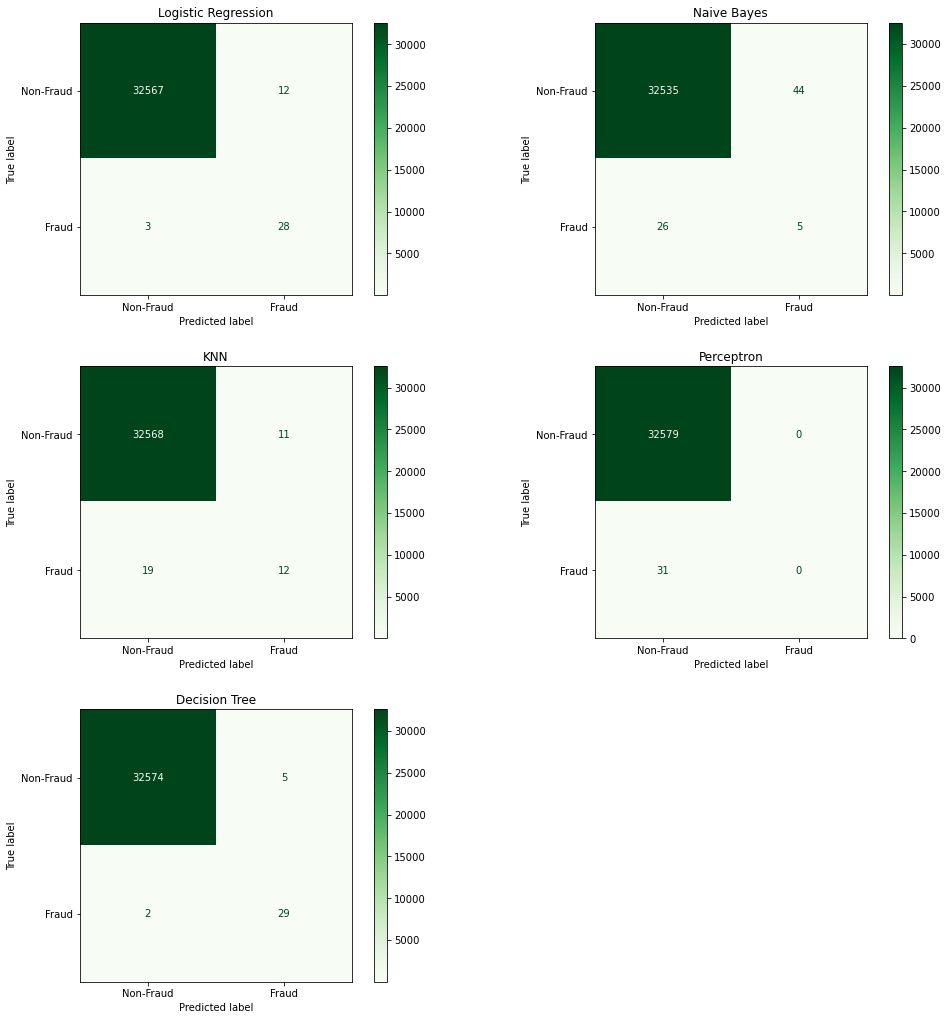

In [37]:
benchtest_1.plot_confusion_matrix(['Non-Fraud', 'Fraud'])

**Observations:**

- All classification models got high accuracy rate (>99%)
- Decision Tree and Logistic Regression resulted with a good precision and recall, despite the imbalanced training data. 
- KNN, Naive Bayes, and Perceptron resulted with low recall. These models have been greatly affected by the imbalanced data, resulting it to have high bias on predicting the majority of the class. 

**Correlation Matrix (Unbalanced Data)**

<AxesSubplot:>

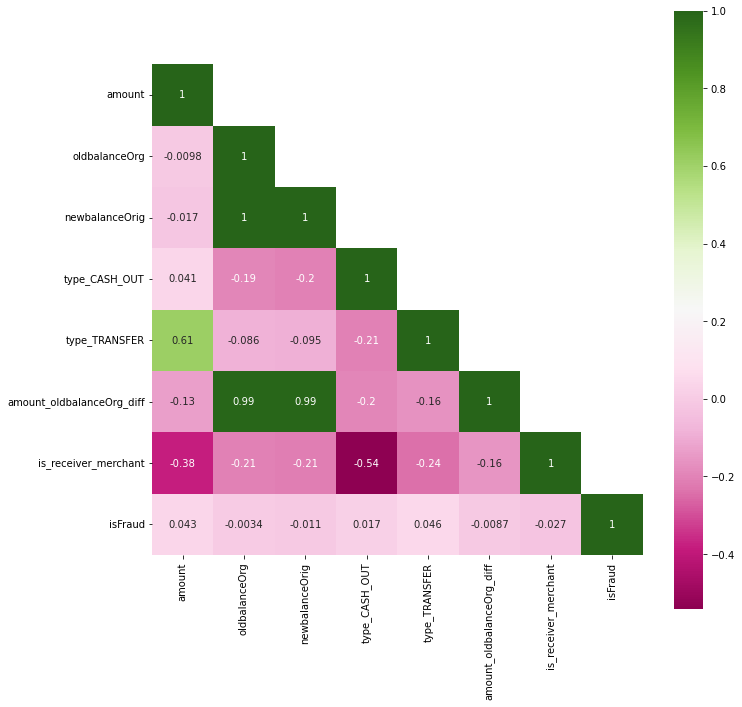

In [38]:
train_set = pd.concat([X_train, y_train], axis=1)
corr_mat = train_set.corr('pearson')
mask = np.triu(corr_mat, 1)
plt.figure(figsize=(11,11))
sns.heatmap(corr_mat, cmap='PiYG', annot=True, square=True, mask=mask)

**Observations:**

- The correlation between each feature and the target is quite low. It seems that the correlation between the feature and target columns are affected by the unbalanced data.

#### **Bench Test # 2: Balanced Data through Upsampling**

Due to data imbalance in our data, the models had difficulty in classifying the minority class. We could use upsampling method to add more samples in the minority class, therefore giving them equal weight and removing bias.

In [39]:
Xy_train = pd.concat([X_train, y_train], axis=1)

print('Training Data Distribution Before Upsampling')
print(Xy_train['isFraud'].value_counts())

Training Data Distribution Before Upsampling
0    76001
1       89
Name: isFraud, dtype: int64


In [40]:
from sklearn.utils import resample

majority = Xy_train[Xy_train['isFraud'] == 0]
minority = Xy_train[Xy_train['isFraud'] == 1]

minority_upsampled = resample(
    minority,
    replace = True,
    n_samples = len(majority),
    random_state = 42
)
Xy_train_balanced = pd.concat([majority, minority_upsampled], ignore_index=True)

print('Training Data Distribution After Upsampling')
print(Xy_train_balanced['isFraud'].value_counts())

Training Data Distribution After Upsampling
0    76001
1    76001
Name: isFraud, dtype: int64


In [41]:
X_train_balanced = Xy_train_balanced.drop('isFraud', axis=1)
y_train_balanced = Xy_train_balanced['isFraud']

**Running Testbench # 2**

In [42]:
bench_test_2 = model_benchtest(X_train_balanced, y_train_balanced, X_test, y_test)
bench_test_2.get_performance_metrics_df()

,model,accuracy,precision,recall,f1_score
4,Decision Tree,99.984667,88.235294,96.774194,92.307692
2,KNN,99.782275,26.190476,70.967742,38.260870
3,Perceptron,92.146581,1.158301,96.774194,2.289203
0,Logistic Regression,90.696105,0.979432,96.774194,1.939237
1,Naive Bayes,17.764489,0.115465,100.000000,0.230663


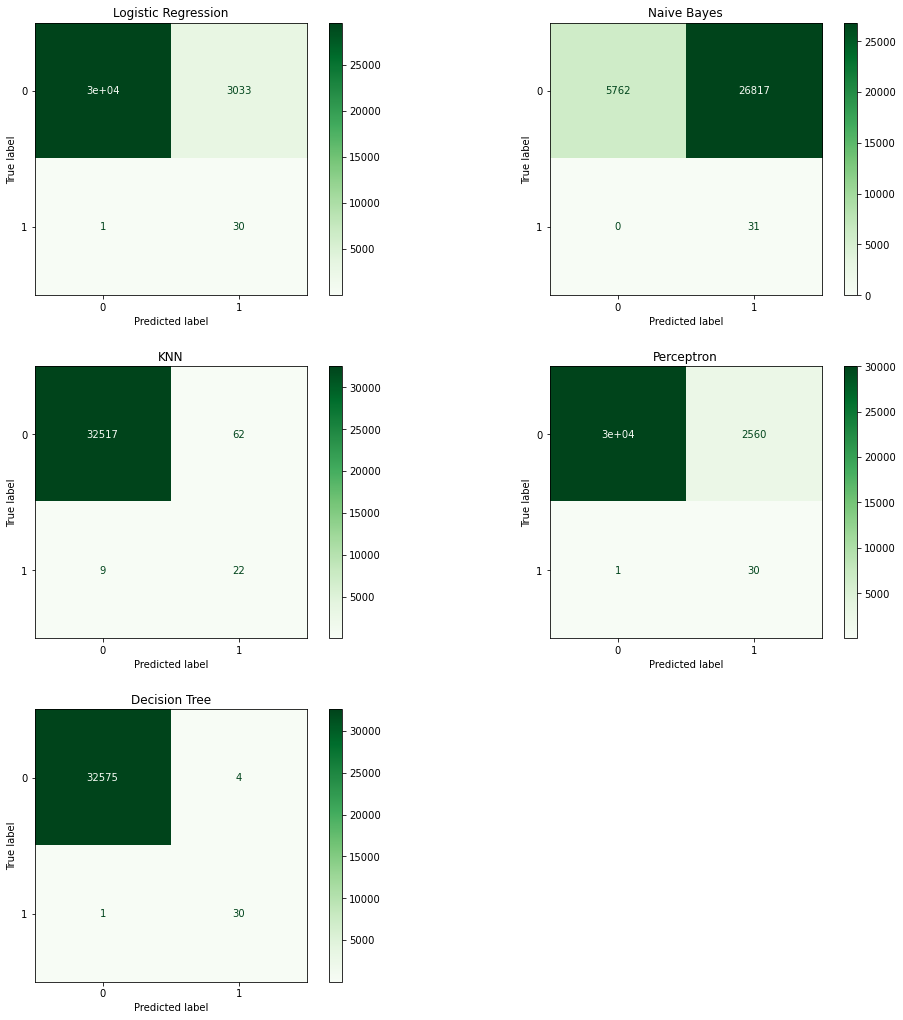

In [43]:
bench_test_2.plot_confusion_matrix()

**Observations:**
    
- After applying upsampling to the training dataset, the **recall of each model increased**.
- **Naive Bayes** may have the **highest recall**, but its **accuracy and precision** is **very low**.
- Both **Logistic Regression** and **Perceptron** improved its **recall**, however its **precision sharply dropped**.
- **Decision Tree** further **improved** its **accuracy and precision**, its **recall** stayed the **same**.
- **KNN** improved its **recall**, but its **precision** got **lower**.

**Correlation Matrix (Balanced Data)**

<AxesSubplot:>

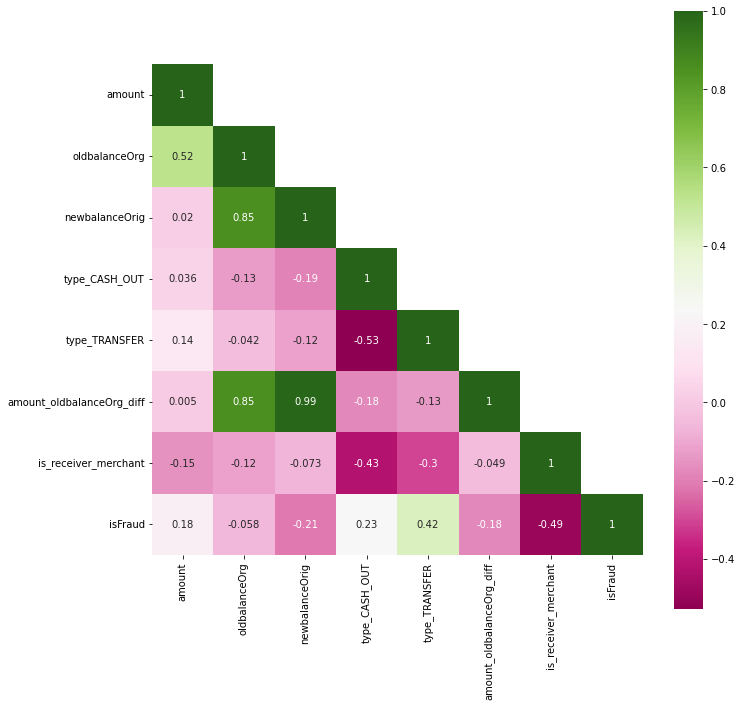

In [44]:
corr_mat = Xy_train_balanced.corr('pearson')
mask = np.triu(corr_mat, 1)
plt.figure(figsize=(11,11))
sns.heatmap(corr_mat, cmap='PiYG', annot=True, square=True, mask=mask)

**Observations:**

- After upsampling the training data, the correlation between each feature and the target **increased significantly**.

#### **Bench Test # 3: Applying Normalization**

Since some columns have very large values relative to other columns, it can affect the model's predictive performance. (e.g. 10,000,000 - max value of amount column). Let's try performing normalization on our data and see whether it can improve the performance of our model.

In [45]:
X_train.describe()

,amount,oldbalanceOrg,newbalanceOrig,type_CASH_OUT,type_TRANSFER,amount_oldbalanceOrg_diff,is_receiver_merchant
count,7.609000e+04,7.609000e+04,7.609000e+04,76090.000000,76090.000000,7.609000e+04,76090.000000
mean,1.752841e+05,9.021273e+05,9.178819e+05,0.312367,0.084755,7.268432e+05,0.391379
std,3.478951e+05,2.788050e+06,2.825728e+06,0.463462,0.278518,2.813046e+06,0.488062
min,3.200000e-01,0.000000e+00,0.000000e+00,0.000000,0.000000,-6.388051e+06,0.000000
25%,1.025681e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,-1.336599e+05,0.000000
50%,5.495368e+04,2.020450e+04,0.000000e+00,0.000000,0.000000,-6.378295e+03,0.000000
75%,2.143965e+05,1.998415e+05,2.246992e+05,1.000000,0.000000,1.208447e+05,1.000000
max,1.000000e+07,3.856340e+07,3.893942e+07,1.000000,1.000000,3.828766e+07,1.000000


**We'll use Robust Scaler Transform to scale our data. This is commonly use for scaling data with the presence of outliers.**

In [46]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
scaler = RobustScaler()

X_train_balanced_normalized = scaler.fit_transform(X_train)
X_train_balanced_normalized = pd.DataFrame(X_train_balanced_normalized, columns=X_train_balanced.columns)
X_train_balanced_normalized.describe()

,amount,oldbalanceOrg,newbalanceOrig,type_CASH_OUT,type_TRANSFER,amount_oldbalanceOrg_diff,is_receiver_merchant
count,7.609000e+04,76090.000000,76090.000000,76090.000000,76090.000000,76090.000000,76090.000000
mean,5.894513e-01,4.413111,4.084937,0.312367,0.084755,2.880976,0.391379
std,1.704201e+00,13.951307,12.575605,0.463462,0.278518,11.053028,0.488062
min,-2.691949e-01,-0.101103,0.000000,0.000000,0.000000,-25.074885,0.000000
25%,-2.189524e-01,-0.101103,0.000000,0.000000,0.000000,-0.500115,0.000000
50%,1.782157e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.810476e-01,0.898897,1.000000,1.000000,0.000000,0.499885,1.000000
max,4.871687e+01,192.868833,173.295813,1.000000,1.000000,150.465045,1.000000


**Running Testbench # 3**

In [47]:
bench_test_3 = model_benchtest(X_train_balanced_normalized, y_train, X_test, y_test)
bench_test_3.get_performance_metrics_df()

,model,accuracy,precision,recall,f1_score
0,Logistic Regression,97.730757,3.901170,96.774194,7.500000
1,Naive Bayes,90.824900,1.025471,100.000000,2.030124
2,KNN,99.055504,1.060071,9.677419,1.910828
4,Decision Tree,57.279975,0.222031,100.000000,0.443079
3,Perceptron,99.904937,100.000000,0.000000,0.000000


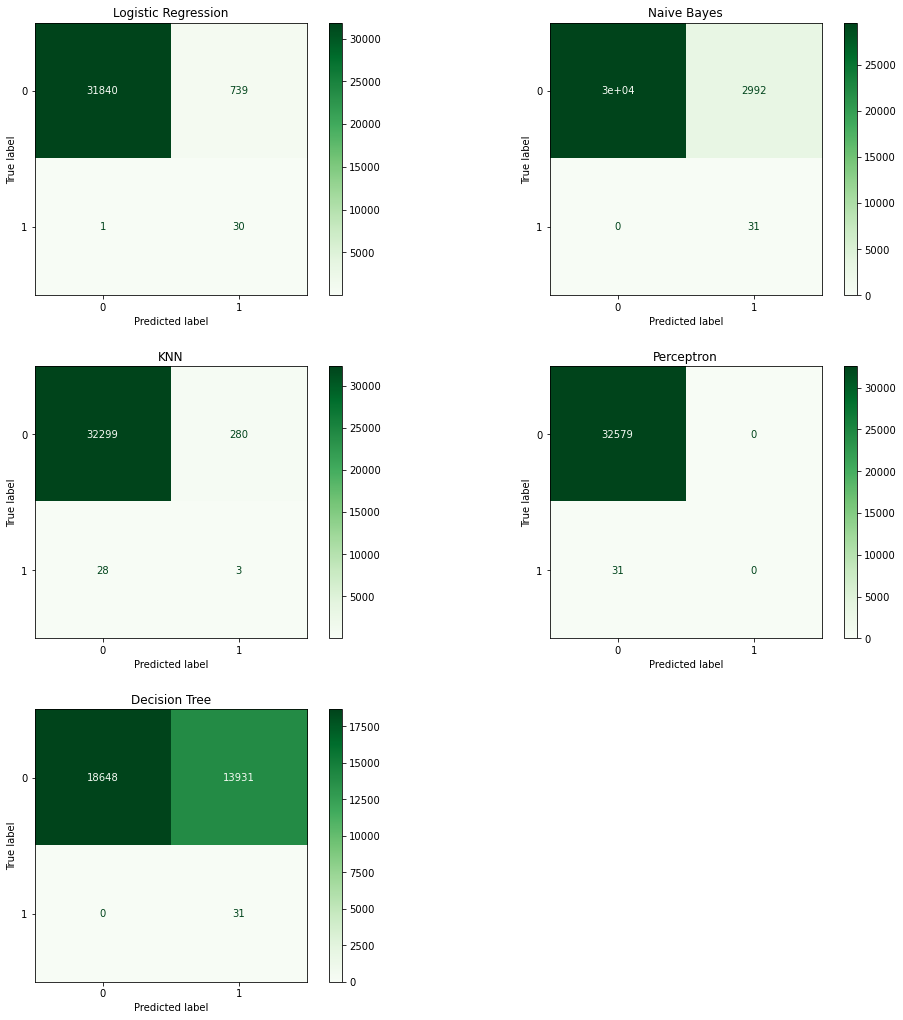

In [48]:
bench_test_3.plot_confusion_matrix()

**Findings**

- After applying normalization to each feature of the training data, **the precision of each model dropped**.
- Since the precision dropped, the **f1 score also decreased**.
- Meanwhile, the **recall of each model increased**.

**Conclusion:**

After trying out different classification algorithm and different strategies such as upsampling and normalization, it shows that the use of **Decision Tree** classification algorithm **with upsampled balanced data** from bench test # 2 yields the **best f1_score performance**.

#### **Feature Importance**

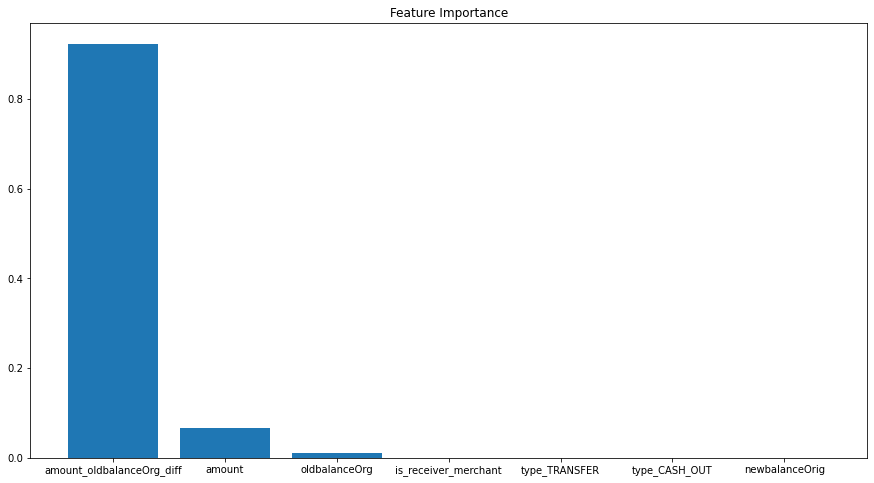

In [49]:
dt_clfr = DecisionTreeClassifier()
dt_clfr.fit(X_train_balanced, y_train_balanced)
importances = dt_clfr.feature_importances_
sort_ind = np.argsort(importances)[::-1]

x = np.arange(len(X_train_balanced.columns))
plt.figure(figsize=(15,8))
plt.bar(x, importances[sort_ind])
plt.xticks(x,tuple(X_train_balanced.columns.values[sort_ind]))
plt.title("Feature Importance")
plt.show()

**Analysis**

- As expected from our the result of our analysis from Exploratory Data Analysis part, it shows that the main predictor of fraud transactions on the dataset seems to be the difference of amount and oldbalanceOrg column values.
- This result doesn't show a quality of a good dataset, since it seems that fraud transaction are just based off on one certain element, which doesn't normally apply in real world scenarios. 

### **Final Thoughts:**

In performing Exploratory Data Analysis, we were able to deep dive through each column of data and find some information out of it. Furthermore, we were also able to create new features that are helpful in identifying fraud transactions and remove some features that seem to be not. 

In building the model, we applied some familiar machine learning algorithms and get to compare their performances after applying some strategies for improving performances. Some strategies works well, while others may not. In the end, we end up with Decision Trees as the best performing algorithm. Decision Trees is fairly new to me, and I'm amazed on its performance despite using it with an unbalanced dataset. I'm looking forward to learn more about this.

Working on the dataset, I realized that there are a lot of different factors for a transaction to be called as fraud, and it can't just be limited based on transactional data. For example, if we could know more information about the customer like financial status, previous transactions, or length period of time usage, we could further determine whether a transaction is truly fraud or not.

From what I found while working on this dataset, I think that the factors of labelling a transaction as fraud is over simplified and doesn't reflect on real world application. Despite that, I believe that this is a good way to start as foundation for further exploring this type of problem in the future.

**References**
- E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016
- https://medium.com/analytics-vidhya/precision-recall-tradeoff-for-real-world-use-cases-c6de4fabbcd0
- https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
- https://machinelearningmastery.com/imbalanced-classification-is-hard/
- https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35
- https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/